# MNIST Performance Evaluation

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import pandas as pd
sys.path.append('../src')
from vae_lightning_utils import load_vae_model
from ours_lightning_utils import load_our_model
from dataset_utils import get_dataset


# Load dataset

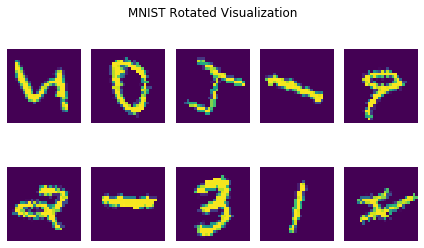

In [2]:
# Load dataset
train_loader, test_loader, image_shape = get_dataset('mnist', 1, 0, data_base_dir='../data/')

# Visualize dataset
fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.arange(0, 10)):
    img, rot, img_rot = train_loader.dataset[i]
    ax.imshow(img.squeeze())
    ax.set_axis_off()
fig.suptitle("MNIST Rotated Visualization")
plt.tight_layout()
plt.show()


## Model predictions

In [3]:
# VAE
out_base_dir = '../output/vae_mnist_20200619_140024'
vae_model = load_vae_model(out_base_dir, train_loader, test_loader, image_shape)
vae_model = vae_model.eval()

# Ours
ours_base_dir = '../output/ours_mnist_20200702_142418'
our_model = load_our_model(ours_base_dir, train_loader, test_loader, image_shape)
our_model = our_model.eval()


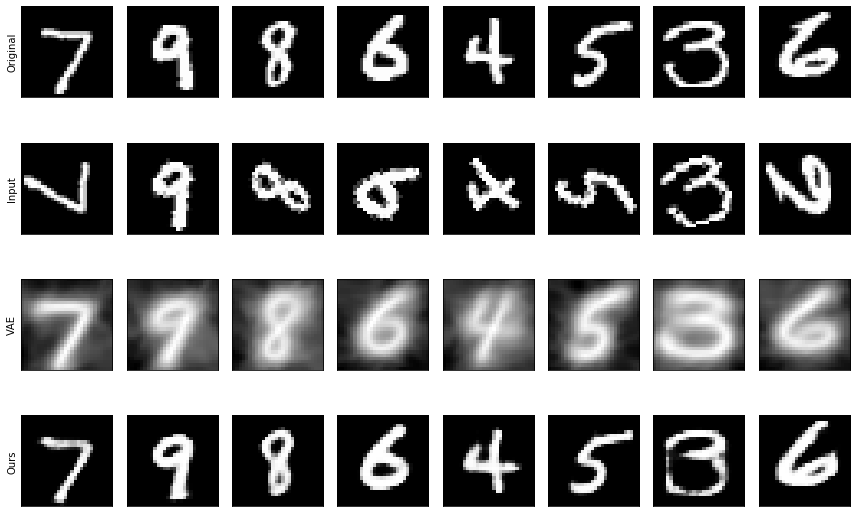

In [4]:
viz_num = 8

viz_idxs = np.linspace(0, len(test_loader.dataset) - 1, viz_num).astype(int)

w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(4, len(viz_idxs), figsize=(w * 2, h * 2), facecolor='w')

for i, idx in enumerate(viz_idxs):
    # Get input and visualize it
    imgs, rot, imgs_rot0 = test_loader.dataset[idx]
    ax = axs[0, i]
    ax.imshow(imgs_rot0.squeeze(), cmap='gray')
    ax = axs[1, i]
    ax.imshow(imgs.squeeze(), cmap='gray')

    # Inference vae
    imgs_vae = vae_model.forward(vae_model.x_coord, imgs, theta_input=0)[0].detach().numpy()
    ax = axs[2, i]
    ax.imshow(imgs_vae.squeeze(), cmap='gray')

    # Inference ours
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    ax = axs[3, i]
    ax.imshow(gen_imgs.squeeze(), cmap='gray')

[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]

axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Input')
axs[2, 0].set_ylabel('VAE')
axs[3, 0].set_ylabel('Ours')

plt.tight_layout()
plt.show()


## 1. Calculate average MSE 

mean MSE vae:  66.07670117785395 std:  17.258002269558546
mean MSE ours: 0.019587841542460484 std: 0.014690775393970271


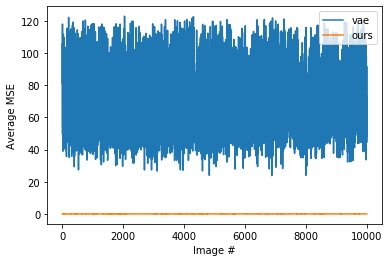

In [33]:
eval_num = 10000

eval_idxs = np.linspace(0, len(test_loader.dataset) - 1, eval_num).astype(int)

mse_vae = np.zeros([eval_num,1])
mse_ours = np.zeros([eval_num,1])
worst_mse_vae, worst_mse_ours = 0, 0
for i, idx in enumerate(eval_idxs):
    # Get input and visualize it
    imgs, rot, imgs_rot0 = test_loader.dataset[idx]
    
    # Inference vae
    imgs_vae = vae_model.forward(vae_model.x_coord, imgs, theta_input=0)[0].detach().numpy()
    mse_vae[i] = np.sum( np.power(imgs_vae - imgs_rot0.detach().numpy(),2))/ 784 
    if mse_vae[i] > worst_mse_vae:
        worst_mse_vae = mse_vae[i]
        worst_img_vae_origin = imgs_rot0.detach().numpy()
        worst_img_vae_input = imgs.detach().numpy()
        worst_img_vae = imgs_vae
    
    # Inference ours
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    mse_ours[i] = np.sum( np.power(gen_imgs - imgs_rot0.detach().numpy(),2))/ 784 
    if mse_ours[i] > worst_mse_ours:
        worst_mse_ours = mse_ours[i]
        worst_img_ours_origin = imgs_rot0.detach().numpy()
        worst_img_ours_input = imgs.detach().numpy()
        worst_img_ours = gen_imgs
    
fig1, ax1 = plt.subplots()
ax1.plot(mse_vae, label='vae')
ax1.plot(mse_ours, label='ours')
ax1.set_xlabel('Image #')
ax1.set_ylabel('Average MSE')
ax1.legend()

# Statistics
#print(mse_vae.transpose())
#print(mse_ours.transpose())
print( 'mean MSE vae: ', np.mean(mse_vae), 'std: ', np.std(mse_vae))
print( 'mean MSE ours:', np.mean(mse_ours), 'std:', np.std(mse_ours))

In [12]:
# Print as df
results = [{'Dataset': 'Rotated MNIST',
            'Method': 'Spatial-VAE',
            'Average MSE': np.mean(mse_vae),
           'Average MSE std': np.std(mse_vae),
            'Worst case MSE': np.max(mse_vae)},
          {'Dataset': 'Rotated MNIST',
           'Method': 'Ours',
           'Average MSE': np.mean(mse_ours),
           'Average MSE std': np.std(mse_ours),
           'Worst case MSE': np.max(mse_ours)},
          ]
pd.DataFrame(results).round(2)

,Dataset,Method,Average MSE,Average MSE std,Worst case MSE
0,Rotated MNIST,Spatial-VAE,66.07,17.28,121.82
1,Rotated MNIST,Ours,0.02,0.01,0.18


## 2. Worst-case image

Worst-case image


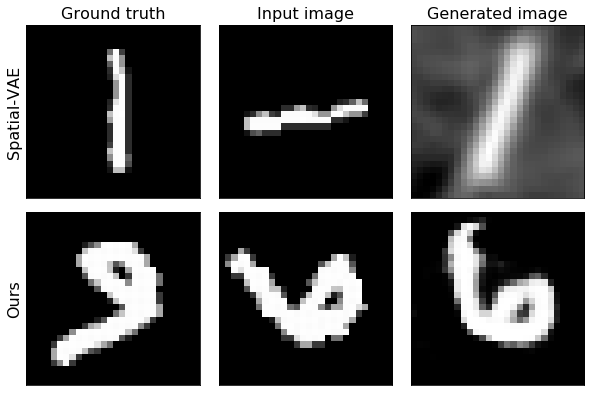

In [34]:
print('Worst-case image')
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(2, 3, figsize=(w * 1.4, h * 1.4), facecolor='w')

images_vae = [worst_img_vae_origin.squeeze(),worst_img_vae_input.squeeze(),worst_img_vae.squeeze()]
images_ours = [worst_img_ours_origin.squeeze(),worst_img_ours_input.squeeze(),worst_img_ours.squeeze()]


axs[0,0].set_ylabel('Spatial-VAE',size=16)
axs[1,0].set_ylabel('Ours',size=16)
    
axs[0,0].set_title('Ground truth',size=16)
axs[0,1].set_title('Input image',size=16)
axs[0,2].set_title('Generated image',size=16)


for i,img in enumerate(images_vae):
    ax = axs[0,i]
    ax.imshow(img, cmap='gray')
for i,img in enumerate(images_ours):
    ax = axs[1,i]
    ax.imshow(img, cmap='gray')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 3.SNR that 'breaks' model

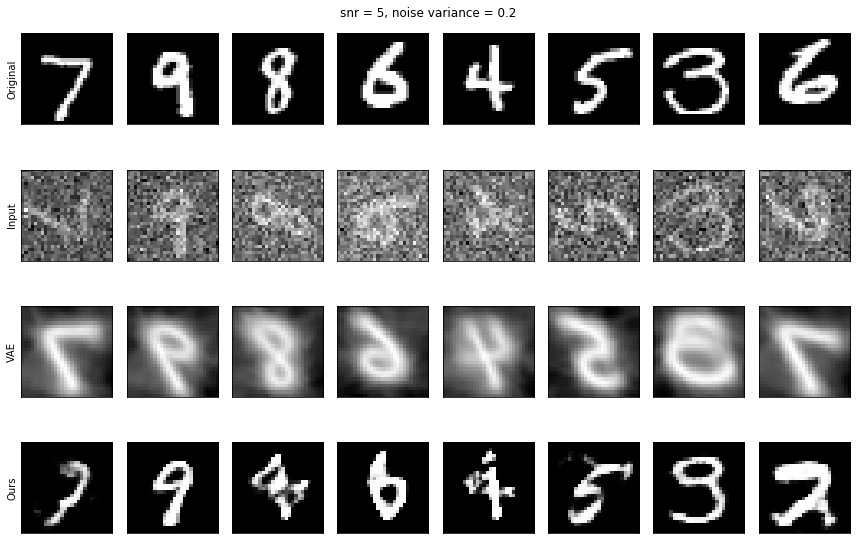

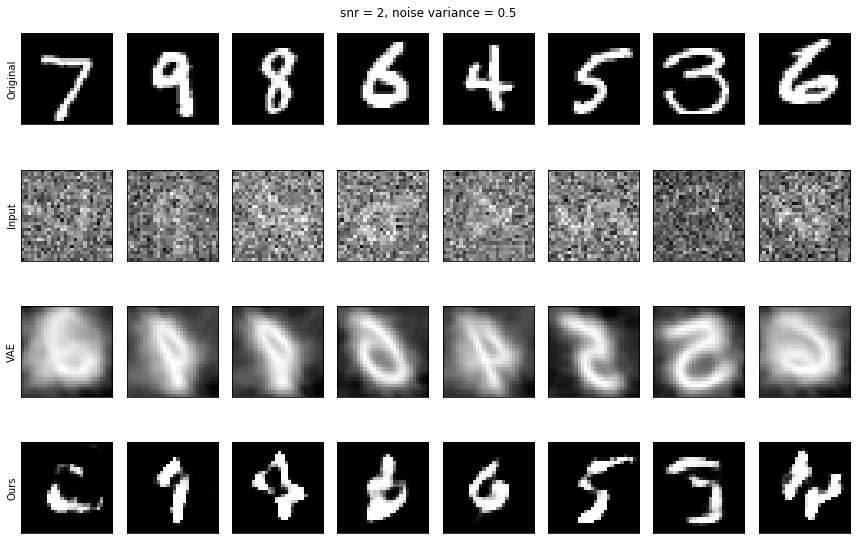

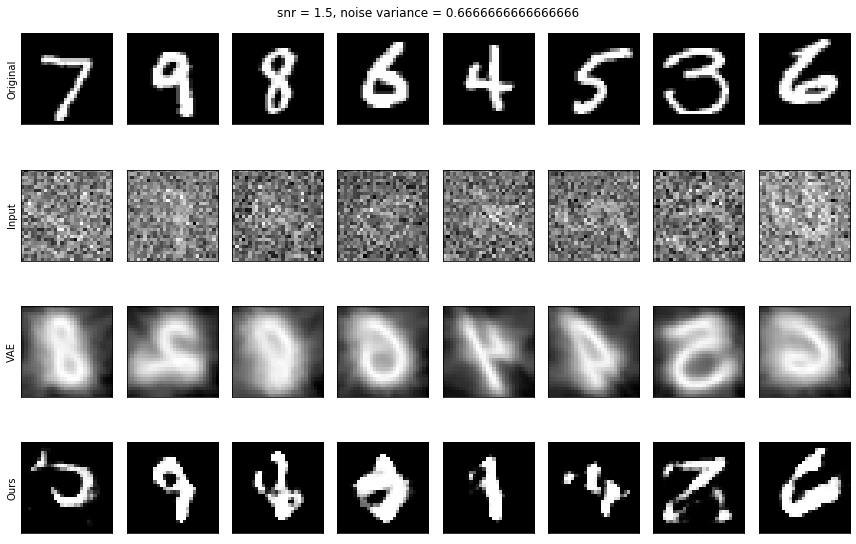

In [7]:
torch.manual_seed(0)
eval_num = 8

eval_idxs = np.linspace(0, len(test_loader.dataset) - 1, eval_num).astype(int)

w, h = plt.rcParams.get('figure.figsize')
#fig, axs = plt.subplots(4, len(viz_idxs), figsize=(w * 2, h * 2), facecolor='w')

for snr in [5, 2, 1.5]:
    fig, axs = plt.subplots(4, len(eval_idxs), figsize=(w * 2, h * 2), facecolor='w')
    fig.suptitle('snr = ' + str(snr) + ', noise variance = ' + str(1/snr))
    
    for i, idx in enumerate(viz_idxs):
        # Get input and visualize it
        imgs, rot, imgs_rot0 = test_loader.dataset[idx]
        ax = axs[0, i]
        ax.imshow(imgs_rot0.squeeze(), cmap='gray')

        noise_var = 1/snr
        imgs = imgs + (noise_var**0.5)*torch.randn(28, 28)

        ax = axs[1, i]
        ax.imshow(imgs.squeeze(), cmap='gray')

        # Inference vae
        imgs_vae = vae_model.forward(vae_model.x_coord, imgs, theta_input=0)[0].detach().numpy()
        ax = axs[2, i]
        ax.imshow(np.flip(imgs_vae.squeeze(), axis=1), cmap='gray')

        # Inference ours
        z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
        gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
        gen_imgs = gen_imgs.detach().numpy()
        ax = axs[3, i]
        ax.imshow(gen_imgs.squeeze(), cmap='gray')

    [ax.set_xticks([]) for ax in axs.flatten()]
    [ax.set_yticks([]) for ax in axs.flatten()]

    axs[0, 0].set_ylabel('Original')
    axs[1, 0].set_ylabel('Input')
    axs[2, 0].set_ylabel('VAE')
    axs[3, 0].set_ylabel('Ours')

    plt.tight_layout()
    plt.show()
